In [1]:
"""
BSM functions (page 52 )
"""

'\nBSM functions (page 52 )\n'

In [32]:
#calculate implied volatility for t =0 , using BSM functions and data from VSTOXX 

In [2]:
from math import log,sqrt,exp
from scipy import stats
import pandas as pd

In [3]:
from pandas import HDFStore, DataFrame

In [4]:
"""
Valuation of European call options in BSM model including 
Vega function and implied volatility estimation
"""

'\nValuation of European call options in BSM model including \nVega function and implied volatility estimation\n'

In [5]:
#Analytical BSM formula

def bsm_call_value(S0,K,T,r,sigma):
    """
    parameters :
    S0 : float ; initial stock / index level
    K  : float ; strike price
    T  : float ; maturity date(in year fractions)
    r  : float ; constant risk free short rate
    sigma : float ; volatility factor in diffusion term
    
    
    Return :
    value : float ; present value of the European call option
    """
    
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma**2)*T )/ (sigma * sqrt(T))
    d2 = (log(S0 / K) + (r - 0.5 * sigma**2)*T )/ (sigma * sqrt(T))
    
    value = (S0 * stats.norm.cdf(d1,0.0,1.0) - K*exp(-r*T) * stats.norm.cdf(d2,0.0,1.0))
    
    return value

In [6]:
# Vega function
def bsm_vega(S0,K,T,r,sigma):
    """
    parameters :
    S0 : float ; initial stock / index level
    K  : float ; strike price
    T  : float ; maturity date(in year fractions)
    r  : float ; constant risk free short rate
    sigma : float ; volatility factor in diffusion term
    
    Return :
    vega : float ; partial derivative of BSM formula with respect to sigma
    """
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma**2)*T )/ (sigma * sqrt(T))
    vega = S0*stats.norm.cdf(d1,0.0,1.0)*sqrt(T)
    return vega

In [7]:
# implied volatility function
def bsm_call_imp_vol(S0,K,T,r,C0,sigma_est,it=100):
    """
    parameters :
    S0 : float ; initial stock / index level
    K  : float ; strike price
    T  : float ; maturity date(in year fractions)
    r  : float ; constant risk free short rate
    sigma_est : float ; estimate of implied volatility
    it : integer ; number of iterations
    
    
    Return :
    sigma_est : float ; numerically estimated implied volatility
    """
    
    for i in range(it):
        sigma_est -=((bsm_call_value(S0,K,T,r,sigma_est) - C0) / bsm_vega(S0,K,T,r,sigma_est))
        
    return sigma_est

In [8]:
# values as per book
# data as uploaded by author
# reference date taken : March 31 , 2014

V0 = 17.6639
r = 0.01

In [17]:
h5 = HDFStore('vstoxx_data_31032014.h5','r')
futures_data = h5['futures_data']
options_data = h5['options_data']  # VSTOXX call option data
print (type(h5))
h5.close()

<class 'pandas.io.pytables.HDFStore'>


In [18]:
futures_data

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,2014-03-31,2014,4,17.85,2014-04-18,0.049
497,2014-03-31,2014,5,19.55,2014-05-16,0.126
498,2014-03-31,2014,6,19.95,2014-06-20,0.222
499,2014-03-31,2014,7,20.40,2014-07-18,0.299
500,2014-03-31,2014,8,20.70,2014-08-15,0.375
501,2014-03-31,2014,9,20.95,2014-09-19,0.471
502,2014-03-31,2014,10,21.05,2014-10-17,0.548
503,2014-03-31,2014,11,21.25,2014-11-21,0.644


In [22]:
#At any time, eight futures are traded on the VSTOXX . 
#Their maturities are the next eight third fridays of the month.
#TTM : time to maturity in year fractions
futures_data.shape

(8, 6)

In [23]:
#options dataset is larger because at any given trading day, multiple 
#call and put options are traded per maturity date .
options_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
DATE         395 non-null datetime64[ns]
EXP_YEAR     395 non-null int64
EXP_MONTH    395 non-null int64
TYPE         395 non-null object
STRIKE       395 non-null float64
PRICE        395 non-null float64
MATURITY     395 non-null datetime64[ns]
TTM          395 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2), object(1)
memory usage: 27.8+ KB


In [21]:
options_data[['DATE','MATURITY','TTM','STRIKE','PRICE']].head()

,DATE,MATURITY,TTM,STRIKE,PRICE
46170,2014-03-31,2014-04-18,0.049,1.0,16.85
46171,2014-03-31,2014-04-18,0.049,2.0,15.85
46172,2014-03-31,2014-04-18,0.049,3.0,14.85
46173,2014-03-31,2014-04-18,0.049,4.0,13.85
46174,2014-03-31,2014-04-18,0.049,5.0,12.85


In [25]:
options_data['IMP_VOL'] = 0.0  # new column for implied volatilities

#calculate implied volatilities for all call options
tol = 0.5 # tolerance level for moneyness

for option in options_data.index :
    #iterating over all option quotes
    forward = futures_data[futures_data['MATURITY'] == options_data.loc[option]['MATURITY']]['PRICE'].values[0]
    
    #picking the right futures value
    if(forward*(1-tol) < options_data.loc[option]['STRIKE'] < forward * (1+tol)):
        #only for options with moneyness within tolerance
        imp_vol = bsm_call_imp_vol(V0,options_data.loc[option]['STRIKE'],options_data.loc[option]['TTM'],r,options_data.loc[option]['PRICE'],sigma_est = 2.,it=100)
        
        options_data['IMP_VOL'].loc[option] = imp_vol
        
        

/home/cassandra/Shikha/pythonvirtual/local/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [26]:
#only use subset of the options_data for which
#implied volatilities were calculated
plot_data = options_data[options_data['IMP_VOL']>0]
#use set() to remove duplicates. then sort the entries
maturities = sorted(set(options_data['MATURITY']))
maturities

[Timestamp('2014-04-18 00:00:00'),
 Timestamp('2014-05-16 00:00:00'),
 Timestamp('2014-06-20 00:00:00'),
 Timestamp('2014-07-18 00:00:00'),
 Timestamp('2014-08-15 00:00:00'),
 Timestamp('2014-09-19 00:00:00'),
 Timestamp('2014-10-17 00:00:00'),
 Timestamp('2014-11-21 00:00:00')]

/home/cassandra/Shikha/pythonvirtual/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


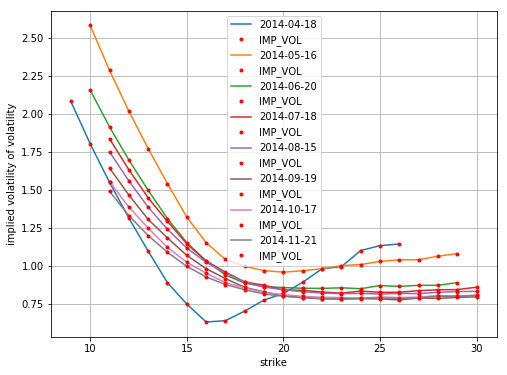

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,6))
for maturity in maturities:
    data = plot_data[options_data.MATURITY == maturity]
    plt.plot(data['STRIKE'],data['IMP_VOL'], label = maturity.date() , lw = 1.5)
    plt.plot(data['STRIKE'],data['IMP_VOL'],'r.')
plt.grid(True)
plt.xlabel('strike')
plt.ylabel('implied volatility of volatility')
plt.legend()
plt.show()


In [29]:
#group by maturity, then strike and keep the price and impl vol columns

keep = ['PRICE','IMP_VOL']
group_data = plot_data.groupby(['MATURITY','STRIKE'])[keep] # DataFrameGroupBy object is returned
group_data

In [30]:
# ?? to egt the data we need to apply an aggregation op on the object eg sum. taking the sum yields the single data point since there is only one data element in every group
group_data = group_data.sum()
group_data.head()

PRICE   IMP_VOL
MATURITY   STRIKE                 
2014-04-18 9.0      8.85  2.083386
           10.0     7.85  1.804194
           11.0     6.85  1.550283
           12.0     5.85  1.316103
           13.0     4.85  1.097184

In [31]:
# all values that the indices (maturity and strike) can take
group_data.index.levels

FrozenList([[2014-04-18 00:00:00, 2014-05-16 00:00:00, 2014-06-20 00:00:00, 2014-07-18 00:00:00, 2014-08-15 00:00:00, 2014-09-19 00:00:00, 2014-10-17 00:00:00, 2014-11-21 00:00:00], [9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]])